In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys

import librosa
import librosa.display

from sklearn.preprocessing import OneHotEncoder

from IPython.display import Audio
import noisereduce as nr

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from collections import Counter

from matplotlib.colors import ListedColormap

from pathlib import Path
import os


from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from PIL import Image
from wordcloud import WordCloud



from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


import time
import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor



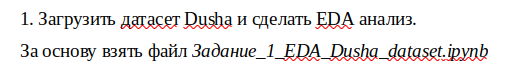

In [2]:
def load_data(path, columns_to_drop=['hash_id', 'source_id']):
    df = pd.read_json(path, lines=True).drop(columns=columns_to_drop)
    df['audio_path'] = df['audio_path'].apply(lambda x: x[6:])
    df = df[df['annotator_emo'] != 'other']
    df = df[df['duration'] <= 10.0]
    return df

In [3]:
podcast_train = load_data('podcast/podcast_train/raw_podcast_train.jsonl')
podcast_test = load_data('podcast/podcast_test/raw_podcast_test.jsonl')
crowd_train = load_data('crowd/crowd_train/raw_crowd_train.jsonl')
crowd_test = load_data('crowd/crowd_test/raw_crowd_test.jsonl')

In [4]:
podcast_train.head()

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo
0,57b7099a4f5766105d166e2283066fa.wav,4.4,neutral,NaN,a6aea16a81aa926eee405c0878162c91,NaN,NaN
1,107b749055d85d7c09ac49fd30e3feb.wav,3.8,neutral,2.0,a6aea16a81aa926eee405c0878162c91,NaN,NaN
2,00b3a5644a0824831848c346d11c7d6.wav,2.5,neutral,NaN,a6aea16a81aa926eee405c0878162c91,NaN,NaN
3,8c053899135f139e9527c1388790e36.wav,1.7,neutral,NaN,a6aea16a81aa926eee405c0878162c91,NaN,NaN
4,fe59996e0f93b8a63e28aacf480004b.wav,1.9,neutral,NaN,a6aea16a81aa926eee405c0878162c91,NaN,NaN


In [5]:
crowd_train.head()

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo
0,75e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry
1,f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral
2,937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,None,None
3,b0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral
4,96dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral


In [6]:
podcast_train.shape, podcast_test.shape, crowd_train.shape, crowd_test.shape

((643836, 7), (83156, 7), (891372, 7), (77981, 7))

In [7]:
podcast_train.annotator_emo.unique()

array(['neutral', 'sad', 'angry', 'positive'], dtype=object)

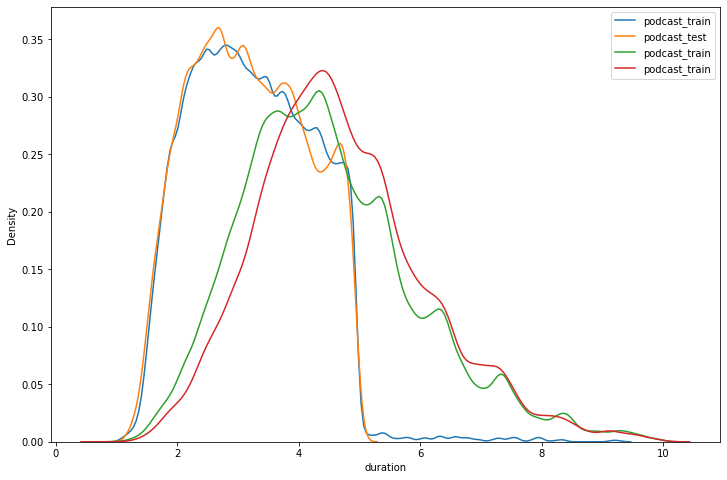

In [8]:
plt.figure(figsize=(12, 8))
sns.distplot(podcast_train['duration'], label='podcast_train', hist=False)
sns.distplot(podcast_test['duration'], label='podcast_test', hist=False)
sns.distplot(crowd_train['duration'], label='podcast_train', hist=False)
sns.distplot(crowd_test['duration'], label='podcast_train', hist=False)

plt.legend()

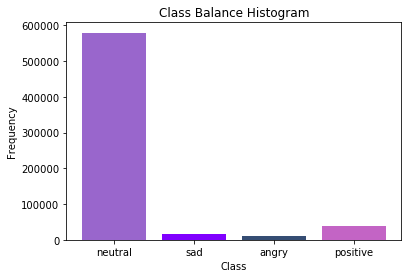

In [9]:
labels =  podcast_train.annotator_emo.tolist()

label_counts = Counter(labels)

classes = label_counts.keys()
counts = label_counts.values()
cmap = ListedColormap(['#9966CC', '#8000FF', '#354D73', '#C364C5', '#660066'])

# Create the histogram
plt.bar(classes, counts, color=cmap(np.arange(len(classes))))

# Optionally, set the title and labels
plt.title('Class Balance Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Show the plot
plt.show()

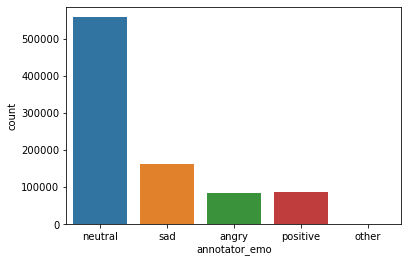

In [10]:
sns.countplot(x='annotator_emo', data=crowd_train, order=['neutral', 'sad', 'angry', 'positive', 'other'])

In [11]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar()

def create_mfcc(data, sr, e):
    plt.figure(figsize=(11, 3))
    mfcc = librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()
    plt.show()
    plt.plot(np.mean(mfcc.T, axis=0))
    plt.show()
    return mfcc

In [12]:
emo = 'sad'

row = 1

print(crowd_train[crowd_train['annotator_emo'] == emo].iloc[row])

steam_dir = Path('crowd/crowd_train/wavs')
path = list(steam_dir.glob(f"*{crowd_train[crowd_train['annotator_emo'] == emo]['audio_path'].iloc[row]}"))[0]

# path =  os.path.join('crowd/crowd_train/wavs', '1'+crowd_train[crowd_train['annotator_emo'] == emo]['audio_path'].iloc[3])
data, sr = librosa.load(path)
data = nr.reduce_noise(data, sr=sr)
xt, index = librosa.effects.trim(data, top_db=33)
display(Audio(xt, rate=sr))

audio_path       68925cd6b707ed2713ab0c3f8728cd2.wav
duration                                        5.06
annotator_emo                                    sad
golden_emo                                       3.0
annotator_id        858305a5450b7bd1288ba0053b1cd1c1
speaker_text                                    None
speaker_emo                                     None
Name: 21, dtype: object


0.10.1


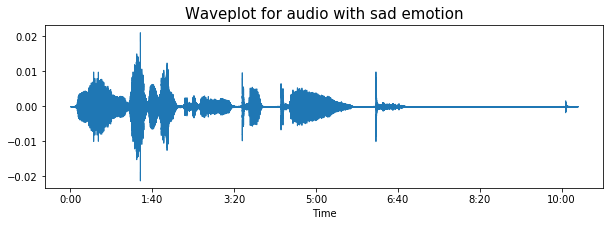

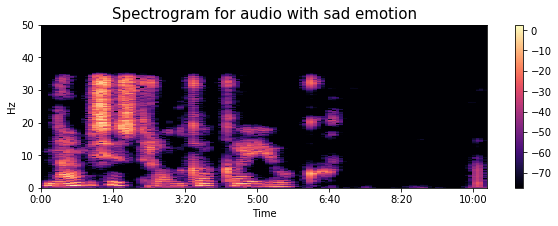

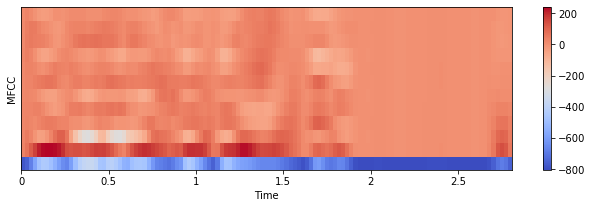

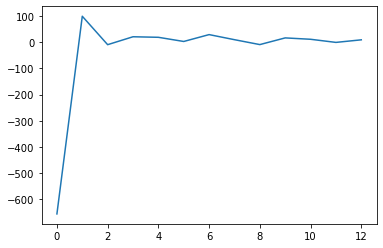

In [13]:
sampling_rate = 100

print(librosa.__version__)

create_waveplot(xt, sampling_rate, emo)
create_spectrogram(xt, sampling_rate, emo)
mfcc_p = create_mfcc(xt, sampling_rate, emo)
# Audio(path)


Text(0.5, 1.0, 'Mean MFCC на Crowd, после предобработки')

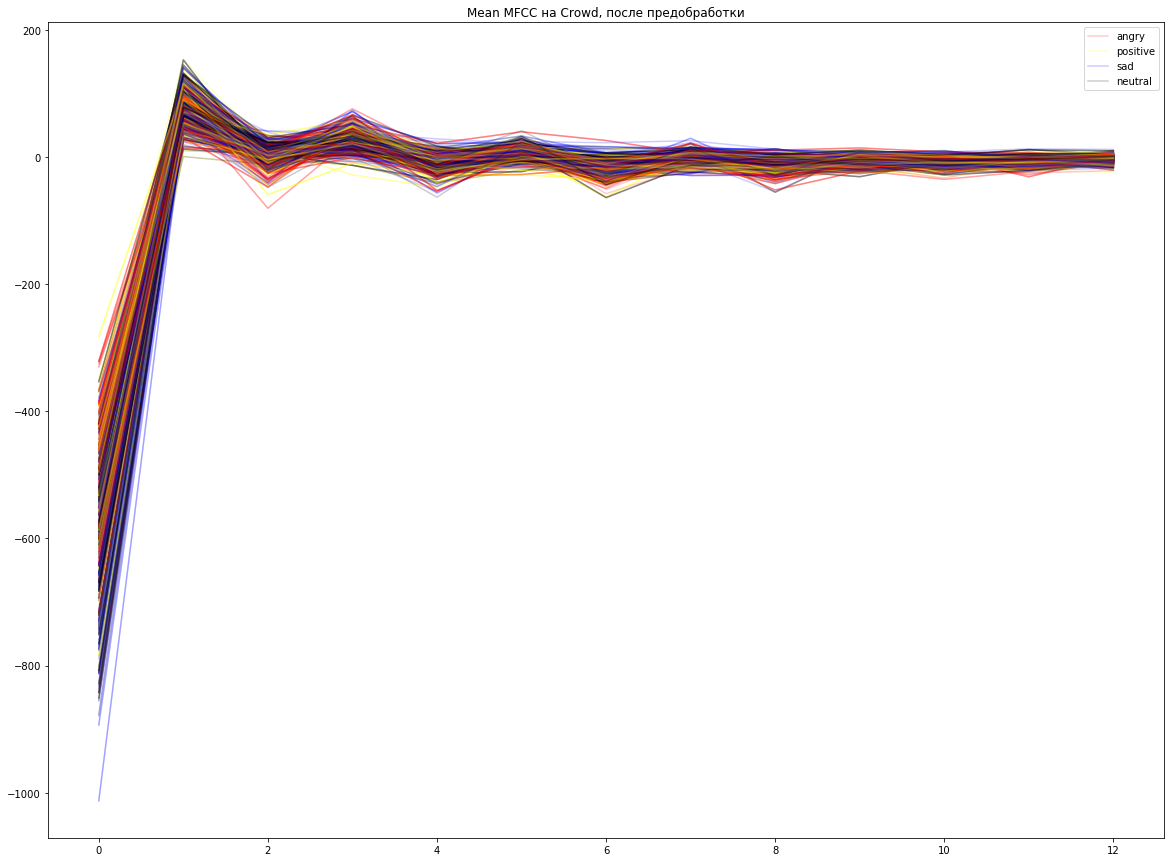

In [14]:
plt.figure(figsize=(20, 15))
colors = ['', 'black', 'yellow', 'blue', '', 'red']
for i in range(200):
    for emo in ['angry', 'positive', 'sad', 'neutral']:
        steam_dir = Path('crowd/crowd_train/wavs')
        path = list(steam_dir.glob(f"*{crowd_train[crowd_train['annotator_emo'] == emo]['audio_path'].iloc[i]}"))[0]
        data, sr = librosa.load(path)
        data = nr.reduce_noise(data, sr=sr)
        data, index = librosa.effects.trim(data, top_db=33)
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13), axis=1)
        if i==0:
            plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2, label=emo)
        else:
            plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2)
plt.legend()
plt.title('Mean MFCC на Crowd, после предобработки')

"При анализе эмоций есть сложность в интрепретации результатов, то есть есть неоднозначность при интерпретации эмоции у тех, кто их оценивает. В нашем датасете есть две колонки, эмоции, которые озвучивал актер и то, как эту эмоцию интрепретировали те, кто их оценивал. Но все равно эмоции очень неоднозначные явления, поэтому есть сложности в применении таких датасетов в реальной жизни.

Первая часть нашего датасета состоит из реплик, озвученных с помощью краудсорсинга. Для её формирования прежде всего нужно было получить тексты, которые и будут озвучены. Да, можно было взять тексты из открытых источников и озвучить их, но есть несколько подводных камней. 

    Во-первых, если текст по смыслу негативный, то попытка произнести его с позитивной интонацией будет не очень реалистичной (то же самое, если переставить позитив и негатив местами). 

    Во-вторых, реалистично озвучить какую-то белиберду с эмоциональным окрасом тоже затруднительно. Поэтому нам пришлось немного заморочиться, следите за руками."

Чтобы оценить распределение эмоций в текстах, мы попросили группу разметчиков отнести каждый текст к одной из групп (ниже часть их инструкции для разметки): 

Позитив: хвастается успехами («я получил пятерку»), вокруг происходит что-то хорошее («у нас классная погода», хвалит кого-то («он очень умный»), смех (есть «ха-ха» в тексте), поздравление («с Новым годом»), что-то понравилось («эта песня мне нравится»), хочу дружить/давай дружить.

Грусть: скучно/грустно/печально или плохое настроение, текст, требующий сочувствия («заболел хомячок», «что-то с ногой, хромаю»), что-то не получается («не могу уровень пройти»), жалуется на работу, погоду и т. д., («замучали меня», «я не могу на улицу выйти уже две недели»).

Злость/Раздражение: нецензурная лексика/оскорбления/ угрозы («я тебя сломаю», «слышь, я не буду это делать»)/раздражение («ты врёшь мне», «я сказала выйти из меню»)/что-то не работает, не включается.

Нейтраль: если текст не подходит ни под одну из всех остальных эмоций/люди запрашивают музыку, фильм или какой-то другой контент.

Совсем непонятно: так предлагалось помечать записи, если текст совсем несвязный.

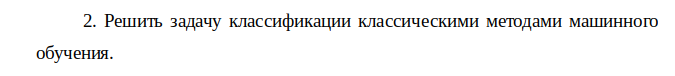

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D, Reshape
# from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from keras.callbacks import ReduceLROnPlateau
from keras.initializers import glorot_uniform

from IPython.display import Audio
import noisereduce as nr

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2023-12-24 12:05:47.230406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 12:05:48.806868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())

True


In [61]:
all_words = ' '.join(crowd_train['speaker_text'].dropna().to_list()).split()
all_words[:10]

['не', 'надо', 'не', 'надо', 'не', 'надо', 'не', 'надо', 'фозил', 'кори']

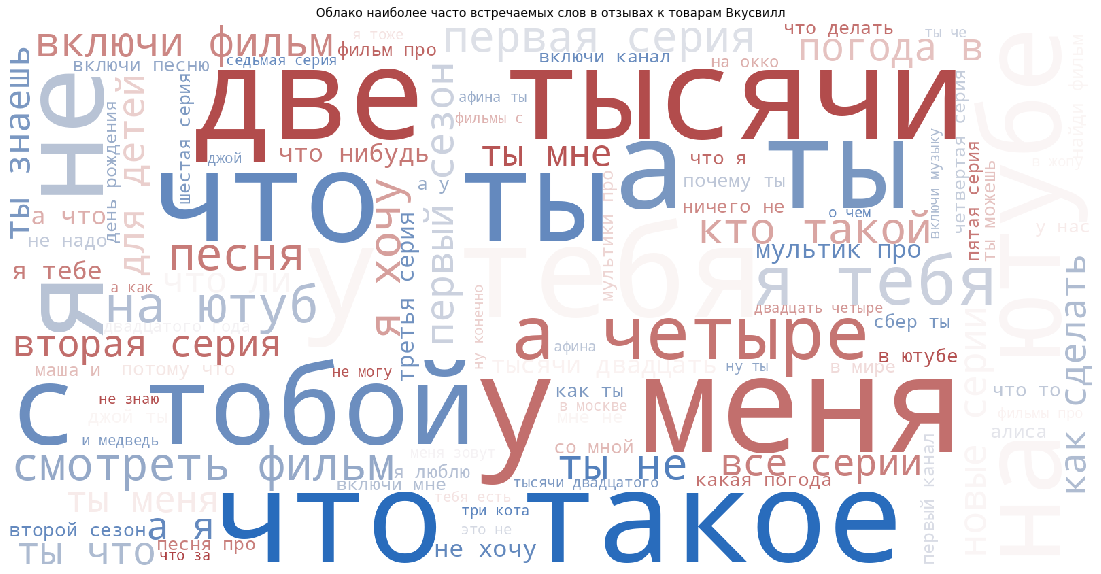

In [64]:
text_wordcloud= ' '.join(map(str, all_words)) 
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=100, colormap='vlag',background_color="white", collocations=True).generate(text_wordcloud)

# Визуализация 
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title('Облако наиболее часто встречаемых слов в отзывах к товарам Вкусвилл')
plt.axis("off")
plt.show()

In [8]:
# Возьмем из датасета эмоции поровну

N = 1000
positive = (crowd_train[crowd_train["annotator_emo"] == 'positive']).sample(N, random_state=42)
sad = (crowd_train[crowd_train["annotator_emo"] == 'sad']).sample(N, random_state=42)
neutral = (crowd_train[crowd_train["annotator_emo"] == 'neutral']).sample(N, random_state=42)
angry = (crowd_train[crowd_train["annotator_emo"] == 'angry']).sample(N, random_state=42)
crowd_train_resampled = pd.concat([positive, sad, neutral, angry], axis=0)

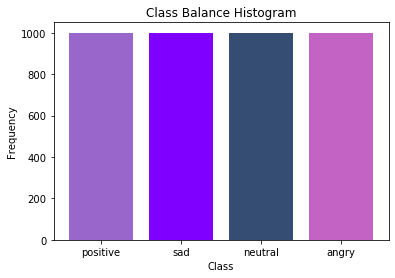

In [9]:
# train dataset

labels =  crowd_train_resampled.annotator_emo.tolist()

label_counts = Counter(labels)

classes = label_counts.keys()
counts = label_counts.values()
cmap = ListedColormap(['#9966CC', '#8000FF', '#354D73', '#C364C5', '#660066'])

# Create the histogram
plt.bar(classes, counts, color=cmap(np.arange(len(classes))))

# Optionally, set the title and labels
plt.title('Class Balance Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Show the plot
plt.show()

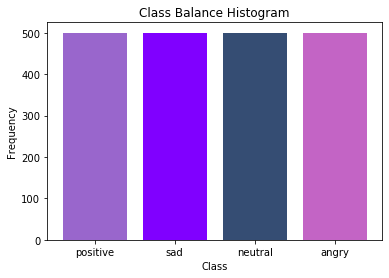

In [12]:
# test dataset

N = 500
positive = (crowd_test[crowd_test["annotator_emo"] == 'positive']).sample(N, random_state=42)
sad = (crowd_test[crowd_test["annotator_emo"] == 'sad']).sample(N, random_state=42)
neutral = (crowd_test[crowd_test["annotator_emo"] == 'neutral']).sample(N, random_state=42)
angry = (crowd_test[crowd_test["annotator_emo"] == 'angry']).sample(N, random_state=42)
crowd_test_resampled = pd.concat([positive, sad, neutral, angry], axis=0)

labels =  crowd_test_resampled.annotator_emo.tolist()

label_counts = Counter(labels)

classes = label_counts.keys()
counts = label_counts.values()
cmap = ListedColormap(['#9966CC', '#8000FF', '#354D73', '#C364C5', '#660066'])

# Create the histogram
plt.bar(classes, counts, color=cmap(np.arange(len(classes))))

# Optionally, set the title and labels
plt.title('Class Balance Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [14]:
# Сделаем предобработку текста
crowd_train_resampled = crowd_train_resampled.dropna(subset=['audio_path', 'annotator_emo'])
crowd_train_resampled = crowd_train_resampled[['audio_path', 'annotator_emo']]

crowd_test_resampled = crowd_test_resampled.dropna(subset=['audio_path', 'annotator_emo'])
crowd_test_resampled = crowd_test_resampled[['audio_path', 'annotator_emo']]


# path =  os.path.join('crowd/crowd_train/wavs', '1'+crowd_train[crowd_train['annotator_emo'] == emo]['audio_path'].iloc[3])

In [18]:
# загрузим аудиофайлы и выявим признаки
def extract_features(audio_path):
    steam_dir = Path('crowd/crowd_train/wavs')
    path = list(steam_dir.glob(f"*{audio_path}"))[0]
    y, sr = librosa.load(path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=9)
    return mfccs.flatten()

crowd_train_resampled['audio_features'] = crowd_train_resampled['audio_path'].apply(extract_features)
    

In [19]:
crowd_train_resampled

,audio_path,annotator_emo,audio_features
450357,68b984019bbdbef96cf1c930657db9b.wav,positive,"[-647.5016, -488.16818, -400.6227, -414.311, -..."
305152,734bb32cb2d783018cb31daae3c11c1.wav,positive,"[-469.7952, -406.72986, -392.86832, -393.41617..."
41158,e9d27dc8e64f0d342ba75b0b1c07983.wav,positive,"[-611.71405, -581.7739, -578.41223, -576.34766..."
108714,c4c16a3533123a3efe3fa43e74b9ffd.wav,positive,"[-555.3371, -553.5367, -459.53024, -425.86264,..."
659647,4268efb5acce4c280f4b50970d844b3.wav,positive,"[-738.67316, -738.67316, -712.4155, -620.93317..."
...,...,...,...
295387,ab2a30f89bbac6d8b87747ef311bf48.wav,angry,"[-756.3613, -715.4638, -611.1163, -571.96954, ..."
127399,84890b04801fa8f6ae720d6c31a3cf2.wav,angry,"[-578.4569, -578.4569, -578.4569, -578.4569, -..."
336885,74347e6e2deeed76044cf3015c7e390.wav,angry,"[-619.8952, -559.20435, -552.4888, -554.6153, ..."
198093,278117a584d3f858c006186cd390590.wav,angry,"[-408.9154, -351.4043, -349.99512, -350.95715,..."


In [22]:
# то же для test

# загрузим аудиофайлы и выявим признаки
def extract_features(audio_path):
    steam_dir = Path('crowd/crowd_test/wavs')
    path = list(steam_dir.glob(f"*{audio_path}"))[0]
    y, sr = librosa.load(path)
    # n_mfcc — количество мел-кепстральных коэффициентов
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=9)
    return mfccs.flatten()

crowd_test_resampled['audio_features'] = crowd_test_resampled['audio_path'].apply(extract_features)

In [85]:
# Преобразуем метку в числовой формат
label_encoder = LabelEncoder()

crowd_train_resampled['label'] = label_encoder.fit_transform(crowd_train_resampled['annotator_emo'])


# test

crowd_test_resampled['label'] = label_encoder.fit_transform(crowd_test_resampled['annotator_emo'])

In [86]:
crowd_train_resampled

,audio_path,annotator_emo,audio_features,label
450357,68b984019bbdbef96cf1c930657db9b.wav,positive,"[-647.5016, -488.16818, -400.6227, -414.311, -...",2
305152,734bb32cb2d783018cb31daae3c11c1.wav,positive,"[-469.7952, -406.72986, -392.86832, -393.41617...",2
41158,e9d27dc8e64f0d342ba75b0b1c07983.wav,positive,"[-611.71405, -581.7739, -578.41223, -576.34766...",2
108714,c4c16a3533123a3efe3fa43e74b9ffd.wav,positive,"[-555.3371, -553.5367, -459.53024, -425.86264,...",2
659647,4268efb5acce4c280f4b50970d844b3.wav,positive,"[-738.67316, -738.67316, -712.4155, -620.93317...",2
...,...,...,...,...
295387,ab2a30f89bbac6d8b87747ef311bf48.wav,angry,"[-756.3613, -715.4638, -611.1163, -571.96954, ...",0
127399,84890b04801fa8f6ae720d6c31a3cf2.wav,angry,"[-578.4569, -578.4569, -578.4569, -578.4569, -...",0
336885,74347e6e2deeed76044cf3015c7e390.wav,angry,"[-619.8952, -559.20435, -552.4888, -554.6153, ...",0
198093,278117a584d3f858c006186cd390590.wav,angry,"[-408.9154, -351.4043, -349.99512, -350.95715,...",0


In [97]:

idx_to_emo = dict(zip([0, 1, 2, 3], label_encoder.inverse_transform([0, 1, 2, 3])))
emo_to_idx = dict(zip(label_encoder.inverse_transform([0, 1, 2, 3]), [0, 1, 2, 3]))
emo_to_idx

{'angry': 0, 'neutral': 1, 'positive': 2, 'sad': 3}

In [30]:
# Сохраним предобработанные данные
crowd_train_resampled.to_pickle ("crowd_train_resampled.pkl")
crowd_test_resampled.to_pickle ("crowd_test_resampled.pkl")

In [31]:
# Загрузим данные
crowd_train_resampled = pd.read_pickle ("crowd_train_resampled.pkl")
crowd_test_resampled = pd.read_pickle ("crowd_test_resampled.pkl")

In [32]:
# Разделим данные на test и train

X_train = crowd_train_resampled['audio_features'].to_list()
y_train = crowd_train_resampled['label']


X_test = crowd_test_resampled['audio_features'].to_list()
y_test = crowd_test_resampled['label']

In [34]:
X_train

[array([-6.47501587e+02, -4.88168182e+02, -4.00622711e+02, -4.14311005e+02,
        -4.43753082e+02, -4.40161804e+02, -4.44742981e+02, -4.64927002e+02,
        -4.80841766e+02, -4.83952148e+02, -4.90379395e+02, -4.94186249e+02,
        -5.00836853e+02, -5.04931458e+02, -5.13937073e+02, -4.70909760e+02,
        -3.92882355e+02, -4.05523651e+02, -5.03237762e+02, -5.16571472e+02,
        -5.16091309e+02, -5.15451538e+02, -5.16791016e+02, -5.15383484e+02,
        -5.16355164e+02, -5.12815308e+02, -5.13677307e+02, -5.13438599e+02,
        -5.10567871e+02, -4.97935791e+02, -4.90252747e+02, -5.07558136e+02,
        -5.22005249e+02, -5.24837646e+02, -5.21311279e+02, -4.51972595e+02,
        -2.69367584e+02, -2.08877884e+02, -2.02868042e+02, -2.25298553e+02,
        -2.51943817e+02, -2.65263702e+02, -2.70718781e+02, -2.47390396e+02,
        -2.00882492e+02, -1.55020706e+02, -1.24578369e+02, -9.53549271e+01,
        -9.80837631e+01, -1.54746521e+02, -2.79649750e+02, -3.62742310e+02,
        -3.8

In [47]:
# Сделаем предобработку признаков
# train

# То есть, максимальная длина 500, все остальное обрезается, если меньше 500, то дополняется нулями в конце(padding=post), тип float32
X_train_padded = pad_sequences(X_train, padding='post', maxlen=500, dtype='float32')

# test
X_test_padded = pad_sequences(X_test, padding='post', maxlen=500, dtype='float32')


In [67]:
X_train_padded

array([[-24.54139  , -26.08701  , -31.880459 , ...,  11.706475 ,
         11.306278 ,  12.300772 ],
       [ 16.743052 ,  16.235657 ,  20.655315 , ..., -21.758444 ,
        -21.088406 , -21.873096 ],
       [-22.218185 , -20.1372   , -22.036562 , ...,  -8.604034 ,
         -9.067988 ,  -6.2768955],
       ...,
       [  7.463271 ,   8.435538 ,   8.943233 , ...,   3.7438025,
          5.6233196,   5.9030094],
       [ 12.0000725,  10.902029 ,   9.637805 , ...,   2.3209274,
          5.966138 ,  10.870055 ],
       [ 26.779501 ,  24.370934 ,  24.5055   , ...,  -4.072465 ,
         -3.9124904,  -3.1695316]], dtype=float32)

In [116]:
# Выберем модели машинного обучения
model1 = RandomForestClassifier(n_estimators=1000, random_state=0) 
model2 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, random_state=0)
model3 = KNeighborsClassifier(n_neighbors= 100)
# print(classification_report(y_test, y_pred))
models = {'Random Forest': model1, 'MLP': model2, 'Neighbors': model3}

# Сохраним результаты
models_res = {'Classifier': [], 'Accuracy': [], 'Train and test time': []}
trained_models = {}

Random Forest


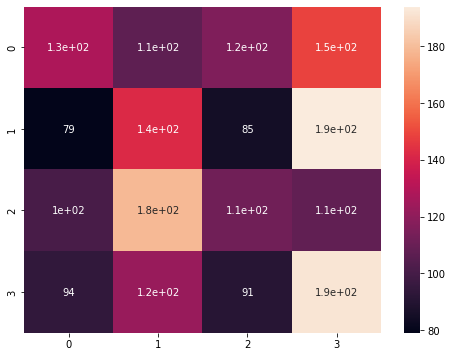

MLP


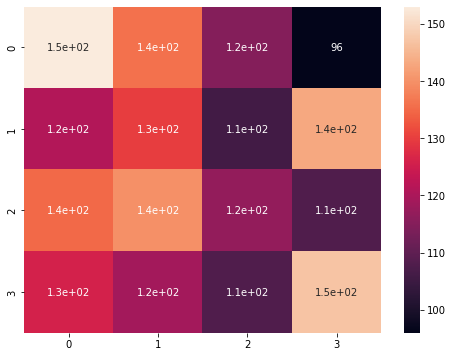

Neighbors


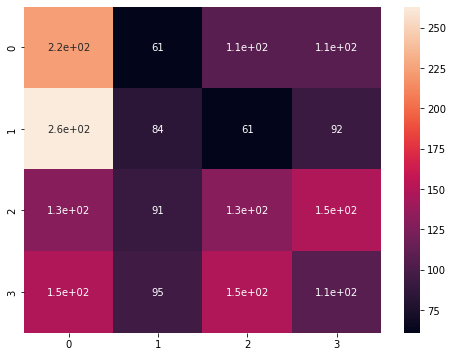

In [117]:
from tqdm.notebook import tqdm


for classifier, model in models.items():
    st_time = time.time()
    model.fit(X_train_padded, y_train)
    y_pred = model.predict(X_test_padded)
    f_time = time.time()
    
    accuracy = accuracy_score(y_test, y_pred)
    # cr = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    
    # сохраним параметры
    models_res['Classifier'].append(classifier)
    models_res['Accuracy'].append(accuracy)
    models_res['Train and test time'].append(f_time - st_time)
    
    print(classifier)
    # sns.heatmap(cr, annot=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True)
    plt.show()
    
    trained_models[classifier] = model

    

In [118]:
pd.DataFrame(models_res)

,Classifier,Accuracy,Train and test time
0,Random Forest,0.2870,86.039440
1,MLP,0.2735,5.514944
2,Neighbors,0.2720,0.385371


In [119]:
# new_audio_path = crowd_test['audio_path'].iloc[0]
# new_audio_path

In [120]:
def extract_features_new_audio(audio_path):
    steam_dir = Path('crowd/crowd_test/wavs')
    path = list(steam_dir.glob(f"*{audio_path}"))[0]
    y, sr = librosa.load(path)
    
    data = nr.reduce_noise(y, sr=sr)
    xt, index = librosa.effects.trim(data, top_db=33)
    display(Audio(xt, rate=sr))
    
    # n_mfcc — количество мел-кепстральных коэффициентов
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=9)
    return mfccs.flatten()


# Провреим работу модели
new_audio_path = crowd_test['audio_path'].iloc[0]
new_audio_feactures = extract_features_new_audio(new_audio_path)
new_audio_feactures_padded = pad_sequences([new_audio_feactures], padding='post', maxlen=500, dtype='float32')

In [121]:
test_results = {'Classifier': [], 'Real_emo': [], 'Predicted_emo': []}
for classifier, model in trained_models.items():
    y_pred = model.predict(new_audio_feactures_padded)
    
    # Декодируем метку
    predicted_emo = idx_to_emo[y_pred[0]]
    real_emo = crowd_test['annotator_emo'].iloc[0]
    
    test_results['Classifier'].append(classifier)
    test_results['Real_emo'].append(real_emo)
    test_results['Predicted_emo'].append(predicted_emo)
    
pd.DataFrame(test_results)
    
    

,Classifier,Real_emo,Predicted_emo
0,Random Forest,neutral,sad
1,MLP,neutral,angry
2,Neighbors,neutral,positive


Мы видим, что модель плохо распознает нейтральные эмоции, впрочем, я тоже, потому что мне показалось, что эмоция грустная

In [122]:
# Протестируем еще аудио
# возьмем другую эмоцию
new_audio_path = crowd_test.loc[crowd_test['annotator_emo'] == 'positive'].iloc[4]['audio_path']
audio_data = crowd_test.loc[crowd_test['annotator_emo'] == 'positive'].iloc[4]

new_audio_feactures = extract_features_new_audio(new_audio_path)
new_audio_feactures_padded = pad_sequences([new_audio_feactures], padding='post', maxlen=500, dtype='float32')

test_results = {'Classifier': [], 'Real_emo': [], 'Predicted_emo': []}
for classifier, model in trained_models.items():
    y_pred = model.predict(new_audio_feactures_padded)
    
    # Декодируем метку
    predicted_emo = idx_to_emo[y_pred[0]]
    real_emo = audio_data['annotator_emo']
    
    test_results['Classifier'].append(classifier)
    test_results['Real_emo'].append(real_emo)
    test_results['Predicted_emo'].append(predicted_emo)
    
pd.DataFrame(test_results)

,Classifier,Real_emo,Predicted_emo
0,Random Forest,positive,sad
1,MLP,positive,sad
2,Neighbors,positive,positive


Рандомный лес показал себя лучше всего. Но при тестировании моделей, мы видим, что все равно много ошибок. Я думаю, это связано не только с акуреси, но и с тем, что предсказание эмоций достаточно сложная задача из-за трудности их интерпретации. 

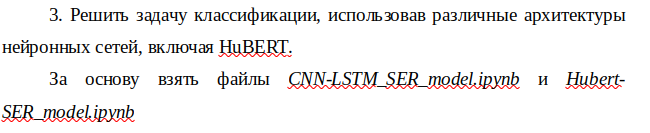

In [6]:
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [7]:
idx_to_emo = {0: 'angry', 1: 'neutral', 2: 'positive', 3: 'sad'}
emo_to_idx = {'angry': 0, 'neutral': 1, 'positive': 2, 'sad': 3}

In [68]:
crowd_train_resampled = pd.read_pickle ("crowd_train_resampled.pkl")
crowd_test_resampled = pd.read_pickle ("crowd_test_resampled.pkl")

# Разделим данные на test и train

X_train = crowd_train_resampled['audio_features'].to_list()
y_train = crowd_train_resampled['label']


X_test = crowd_test_resampled['audio_features'].to_list()
y_test = crowd_test_resampled['label']

# train
X_train_padded = pad_sequences(X_train, padding='post', maxlen=500, dtype='float32')
# test
X_test_padded = pad_sequences(X_test, padding='post', maxlen=500, dtype='float32')


In [69]:
X_train_padded_tensor = torch.tensor(X_train_padded, dtype=torch.float32).unsqueeze(1) # добавим разморность
X_test_padded_tensor = torch.tensor(X_test_padded, dtype=torch.float32).unsqueeze(1) # добавим разморность


y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [70]:
train_dataset = AudioDataset(X_train_padded_tensor, y_train_tensor)
test_dataset = AudioDataset(X_test_padded_tensor, y_test_tensor)

In [71]:
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [72]:
class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN, self).__init__()
        self.conv = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(15936, num_classes)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [73]:
print(len(idx_to_emo))

5


In [74]:
cnn = CNN(input_size=1, num_classes=len(idx_to_emo))

In [75]:
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)


In [76]:
from tqdm.notebook import tqdm


train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
for epoch in range(num_epochs):
    train_epoch_acc = 0
    train_epoch_loss = 0

    for inputs, targets in tqdm(train_loader): 
        cnn.zero_grad()
        outputs = cnn(inputs)
        
       
        train_loss = criterion(outputs, targets)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        
        
        proba = torch.exp(outputs)
        # Возвращает самые большие элементы k заданного тензора input по заданному измерению
        _, pred_nationality = proba.topk(1, dim=1)

        # находим accuracy
        result = pred_nationality == targets.view(pred_nationality.shape)
        acc = torch.mean(result.type(torch.FloatTensor))
        train_epoch_acc += acc.item()
        
    else:
        train_epoch_acc = train_epoch_acc/len(train_dataset)
        train_epoch_loss = train_epoch_loss/len(train_loader)
        with torch.no_grad():
            test_epoch_acc = 0
            test_epoch_loss = 0
            #  мы используем model.eval() , чтобы перевести модель в режим тестирования
            cnn.eval()
            for inputs, targets in tqdm(test_loader):
                
                cnn.zero_grad()
                test_outputs = cnn(inputs)
                test_loss = criterion(test_outputs, targets)
                
                test_epoch_loss += test_loss

    
                proba = torch.exp(test_outputs)
                # Возвращает самые большие элементы k заданного тензора input по заданному измерению
                _, pred_nationality = proba.topk(1, dim=1)

                # находим accuracy
                result = pred_nationality == targets.view(pred_nationality.shape)
                acc = torch.mean(result.type(torch.FloatTensor))
                test_epoch_acc += acc.item()
            else:
                test_epoch_loss = test_epoch_loss/len(test_dataset)
                test_epoch_acc = test_epoch_acc/len(test_dataset)
                
                train_accuracy.append(train_epoch_acc)
                test_accuracy.append(test_epoch_acc)

                train_losses.append(train_epoch_loss)
                test_losses.append(test_epoch_loss)
                print(f'Epoch: {epoch} -> train_loss: {train_epoch_loss:.19f},' 
                    f'train_acc: {train_epoch_acc*100:.2f}%,'
                    f'val_loss: {test_epoch_loss:.19f},'
                    f'val_acc: {test_epoch_acc*100:.2f}%')

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 -> train_loss: 10.9786764402432854837,train_acc: 28.75%,val_loss: 3.4132308959960937500,val_acc: 89.45%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 1 -> train_loss: 1.8041372665967874145,train_acc: 35.83%,val_loss: 2.4974424839019775391,val_acc: 93.40%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 2 -> train_loss: 1.5150485219338842846,train_acc: 38.50%,val_loss: 2.3194928169250488281,val_acc: 102.15%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 3 -> train_loss: 1.4807830415122269496,train_acc: 44.12%,val_loss: 2.0817716121673583984,val_acc: 115.70%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 4 -> train_loss: 1.2351007144844239338,train_acc: 48.05%,val_loss: 2.2071263790130615234,val_acc: 109.75%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 5 -> train_loss: 1.2209470642210678015,train_acc: 50.48%,val_loss: 1.9626491069793701172,val_acc: 122.60%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 6 -> train_loss: 1.2397442082423679732,train_acc: 54.60%,val_loss: 2.1011929512023925781,val_acc: 117.40%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 7 -> train_loss: 1.0773090864988650317,train_acc: 58.65%,val_loss: 1.9070479869842529297,val_acc: 125.55%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 8 -> train_loss: 1.0995193011036876740,train_acc: 59.77%,val_loss: 5.6658821105957031250,val_acc: 92.30%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 9 -> train_loss: 0.9847096483525599186,train_acc: 62.78%,val_loss: 1.3735667467117309570,val_acc: 147.80%


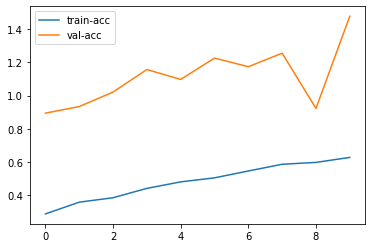

In [77]:
plt.plot(train_accuracy, label='train-acc')
plt.plot(test_accuracy, label='val-acc')

plt.legend()
plt.show()

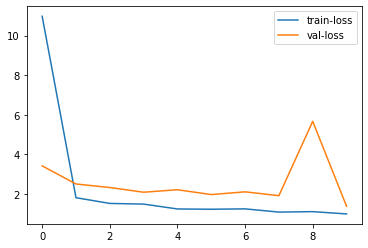

In [78]:
plt.plot(train_losses, label='train-loss')
plt.plot(test_losses, label='val-loss')

plt.legend()
plt.show()

In [12]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        
        # print(embedded.shape, hidden.shape)
        gru_out, hidden = self.gru(input, hidden)
        # Берем только финальный
        output = self.linear(gru_out[:,-1,:]) 
        return output, hidden
    
    def init_hidden(self, batch_size):
         return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [15]:
output_dim = 2
hidden_size = 64


gru = GRU(input_size=500, hidden_size=hidden_size, output_size=len(idx_to_emo))
num_epochs = 20
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

In [16]:
from tqdm.notebook import tqdm




train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
for epoch in range(num_epochs):
    train_epoch_acc = 0
    train_epoch_loss = 0

    for inputs, targets in tqdm(train_loader):
        hidden = gru.init_hidden(inputs.size(0))  
        gru.zero_grad()
        outputs, hidden = gru(inputs, hidden)
        
       
        train_loss = criterion(outputs, targets)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        
        
        proba = torch.exp(outputs)
        # Возвращает самые большие элементы k заданного тензора input по заданному измерению
        _, pred_nationality = proba.topk(1, dim=1)

        # находим accuracy
        result = pred_nationality == targets.view(pred_nationality.shape)
        acc = torch.mean(result.type(torch.FloatTensor))
        train_epoch_acc += acc.item()
        
    else:
        train_epoch_acc = train_epoch_acc/len(train_dataset)
        train_epoch_loss = train_epoch_loss/len(train_loader)
        with torch.no_grad():
            test_epoch_acc = 0
            test_epoch_loss = 0
            #  мы используем model.eval() , чтобы перевести модель в режим тестирования
            gru.eval()
            for inputs, targets in tqdm(test_loader):
                
                hidden = gru.init_hidden(inputs.size(0))  
                gru.zero_grad()
                test_outputs, hidden = gru(inputs, hidden)
                test_loss = criterion(test_outputs, targets)
                
                test_epoch_loss += test_loss

    
                proba = torch.exp(test_outputs)
                # Возвращает самые большие элементы k заданного тензора input по заданному измерению
                _, pred_nationality = proba.topk(1, dim=1)

                # находим accuracy
                result = pred_nationality == targets.view(pred_nationality.shape)
                acc = torch.mean(result.type(torch.FloatTensor))
                test_epoch_acc += acc.item()
            else:
                test_epoch_loss = test_epoch_loss/len(test_dataset)
                test_epoch_acc = test_epoch_acc/len(test_dataset)
                
                train_accuracy.append(train_epoch_acc)
                test_accuracy.append(test_epoch_acc)

                train_losses.append(train_epoch_loss)
                test_losses.append(test_epoch_loss)
                print(f'Epoch: {epoch} -> train_loss: {train_epoch_loss:.19f},' 
                    f'train_acc: {train_epoch_acc*100:.2f}%,'
                    f'val_loss: {test_epoch_loss:.19f},'
                    f'val_acc: {test_epoch_acc*100:.2f}%')

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 -> train_loss: 1.3981700111478567727,train_acc: 29.03%,val_loss: 2.7080123424530029297,val_acc: 66.85%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 1 -> train_loss: 1.3788171769306063474,train_acc: 30.30%,val_loss: 2.7034165859222412109,val_acc: 66.30%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 2 -> train_loss: 1.3681133935675025004,train_acc: 32.12%,val_loss: 2.7093567848205566406,val_acc: 66.75%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 3 -> train_loss: 1.3750309334695338670,train_acc: 31.32%,val_loss: 2.6807837486267089844,val_acc: 70.60%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 4 -> train_loss: 1.3582349530756474554,train_acc: 33.42%,val_loss: 2.6964645385742187500,val_acc: 68.55%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 5 -> train_loss: 1.3638992708027362077,train_acc: 32.45%,val_loss: 2.6667604446411132812,val_acc: 71.60%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 6 -> train_loss: 1.3536847297549248204,train_acc: 33.58%,val_loss: 2.6456627845764160156,val_acc: 73.35%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 7 -> train_loss: 1.3495294029340147990,train_acc: 33.55%,val_loss: 2.6464023590087890625,val_acc: 73.25%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 8 -> train_loss: 1.3430010223984718554,train_acc: 34.73%,val_loss: 2.6375515460968017578,val_acc: 75.40%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 9 -> train_loss: 1.3366456543207168028,train_acc: 36.68%,val_loss: 2.6185071468353271484,val_acc: 75.40%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 10 -> train_loss: 1.3402770550027489627,train_acc: 35.25%,val_loss: 2.6131033897399902344,val_acc: 77.40%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 11 -> train_loss: 1.3373898791223763904,train_acc: 36.15%,val_loss: 2.6143419742584228516,val_acc: 75.55%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 12 -> train_loss: 1.3363624529764055460,train_acc: 35.48%,val_loss: 2.5973136425018310547,val_acc: 78.30%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 13 -> train_loss: 1.3350971899591386194,train_acc: 35.88%,val_loss: 2.6167528629302978516,val_acc: 77.95%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 14 -> train_loss: 1.3256802162826060165,train_acc: 37.15%,val_loss: 2.6228854656219482422,val_acc: 76.05%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 15 -> train_loss: 1.3257684855088591735,train_acc: 35.80%,val_loss: 2.5981130599975585938,val_acc: 78.80%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 16 -> train_loss: 1.3226701505295932471,train_acc: 37.03%,val_loss: 2.6059854030609130859,val_acc: 76.45%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 17 -> train_loss: 1.3178906199485063144,train_acc: 37.23%,val_loss: 2.5706419944763183594,val_acc: 81.00%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 18 -> train_loss: 1.3155180005617439498,train_acc: 38.17%,val_loss: 2.5841796398162841797,val_acc: 79.35%


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 19 -> train_loss: 1.3147434104941786437,train_acc: 37.23%,val_loss: 2.5783910751342773438,val_acc: 79.50%


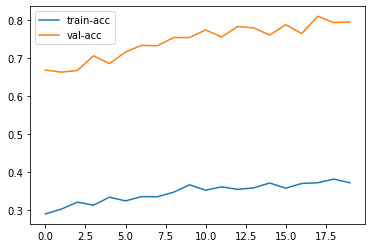

In [17]:
plt.plot(train_accuracy, label='train-acc')
plt.plot(test_accuracy, label='val-acc')

plt.legend()
plt.show()

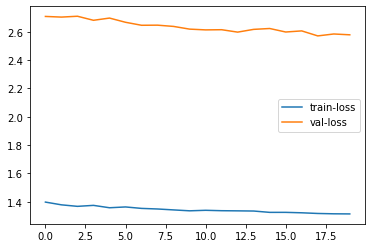

In [18]:
plt.plot(train_losses, label='train-loss')
plt.plot(test_losses, label='val-loss')

plt.legend()
plt.show()

In [86]:
# HuBert
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned")

In [87]:
idx_to_emo = {0: 'neutral', 1: 'angry', 2: 'positive', 3: 'sad', 4: 'other'}
emo_to_idx = {'neutral': 0, 'angry': 1, 'positive': 2, 'sad': 3, 'other': 4}

In [98]:
new_audio_path = crowd_test_resampled.loc[crowd_test_resampled['annotator_emo'] == 'positive'].iloc[16]['audio_path']

real_emo = crowd_test_resampled.loc[crowd_test_resampled['annotator_emo'] == 'positive'].iloc[16]['annotator_emo']

steam_dir = Path('crowd/crowd_test/wavs')
path = list(steam_dir.glob(f"*{new_audio_path}"))[0]

y, sr = librosa.load(path, mono=True)
inputs = feature_extractor(y, sampling_rate=feature_extractor.sampling_rate, return_tensors='pt', padding=True, max_length=1600*10, truncation=True)

In [99]:
input_values = inputs['input_values']
if input_values.dim() == 2 and input_values.shape[0] == 1: 
    batched_input_values = input_values
elif input_values.dim() == 1: 
    batched_input_values = input_values.unsqueeze(0).unsqueeze(0)


logits = model(batched_input_values).logits
predictions = torch.argmax(logits, dim=-1)
predicted_emo = idx_to_emo[predictions.numpy()[0]]
print('Real emo:', real_emo)
print('Predicted emo:', predicted_emo)
Audio(path)

Real emo: positive
Predicted emo: other


Вывод: лучше всего отработала cnn, предобученная модель HuBert неверно определила эмоции, она все определяет как другое

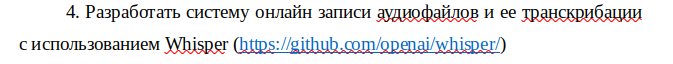

См. файл streamlit_whisper.py

In [ ]:
# import streamlit as st
# import whisper
# import librosa
# import numpy as np
# import io
# from st_audiorec import st_audiorec

# from bokeh.models.widgets import Button
# from bokeh.models import CustomJS
# import base64
# from streamlit.components.v1 import html
# import matplotlib.pyplot as plt
# from PIL import Image


# st.title("Транскриптор аудио")


# st.markdown("![Alt Text](https://media4.giphy.com/media/oGP14S1XBi4yk/200w.webp?cid=ecf05e474f01jb4mtj084vbrxms9z82oh00y0qwxpq88s5jd&ep=v1_gifs_related&rid=200w.webp&ct=g)")


# # online record
# wav_audio_data = st_audiorec()


# # upload audio file with streamlit
# audio_file = st.file_uploader("Загрузить файл", type=["wav", "mp3", "m4a"])


# text = st.text_input("Введите текст")
# tts_button = Button(label="Произнести", width=100)
# tts_button.js_on_event("button_click", CustomJS(code=f"""
#     var u = new SpeechSynthesisUtterance();
#     u.text = "{text}";
#     u.lang = 'ru';
#     speechSynthesis.speak(u);
#     """))
# st.bokeh_chart(tts_button)



# model = whisper.load_model("base")
# st.success("Модель Whisper загружена")


# def display_plots(audio, sr):
#     st.subheader("Waveform")

#     plt.figure(figsize=(10, 3))
#     librosa.display.waveshow(audio, sr=sr)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Amplitude")
#     plt.title("WavePlot")

#     # Save it to a temporary buffer.
#     buf = io.BytesIO()
#     plt.savefig(buf, format="png")
#     # Use PIL to create an image from the new buffer
#     image = Image.open(buf)
#     # Display the image in Streamlit
#     st.image(image, width=800)
    
#     st.subheader("Spectrogram")

#     # Use librosa to calculate the spectrogram
#     S = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)

#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title('Spectrogram')
    
#     # Save it to a temporary buffer again
#     buf = io.BytesIO()
#     plt.savefig(buf, format="png")
#     # Create an image again
#     image = Image.open(buf)
#     # Display the image
#     st.image(image, width=800)

#     # Cleaning up figures to prevent reuse
#     plt.close('all')


# if st.sidebar.button("Траскрибировать аудио"):
#     if audio_file is not None:
#         # Read the audio file as bytes
#         audio_bytes = audio_file.read()
#         # Use librosa to load the audio file from the byte content
#         audio, sr = librosa.load(io.BytesIO(audio_bytes), sr=None)
#         # If model requires single channel (mono) and audio is stereo, take only one channel
#         if len(audio.shape) > 1 and audio.shape[0] == 2:
#             audio = librosa.to_mono(audio)
#         # Convert the audio to the required format
#         if sr != 16000:
#             audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
#         audio_numpy = np.array(audio).astype(np.float32)
        
#         st.sidebar.success("Транскрибирование аудио...")
#         transcription = model.transcribe(audio_numpy)
#         detected_language = transcription.get('language', 'N/A')
#         st.sidebar.success(f"Язык аудио был определен как: {detected_language}")
#         st.sidebar.markdown(transcription["text"])
        
#         display_plots(audio, sr)
       
        
#     if wav_audio_data is not None:
    
#         # Use librosa to load the audio file from the byte content
#         audio, sr = librosa.load(io.BytesIO(wav_audio_data), sr=None)
#         # If model requires single channel (mono) and audio is stereo, take only one channel
#         if len(audio.shape) > 1 and audio.shape[0] == 2:
#             audio = librosa.to_mono(audio)
#         # Convert the audio to the required format
#         if sr != 16000:
#             audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
#         audio_numpy = np.array(audio).astype(np.float32)
        
#         st.sidebar.success("Транскрибирование аудио...")
#         transcription = model.transcribe(audio_numpy)
#         detected_language = transcription.get('language', 'N/A')
#         st.sidebar.success(f"Язык аудио был определен как: {detected_language}")
#         st.sidebar.markdown(transcription["text"])
        
#         display_plots(audio, sr)
        
#     else:
#         st.sidebar.error("Пожалуйста, загрузите аудио файл")
        
# if audio_file is not None:
#     st.sidebar.header("Послушать оригинальную запись")
#     st.sidebar.audio(audio_file)

# if wav_audio_data is not None:
#     st.sidebar.header("Послушать оригинальную запись")
#     st.sidebar.audio(wav_audio_data)
    
    
# # my_js = """
# # console.log(document.getElementById("stop"))
# # """

# # # Wrapt the javascript as html code
# # my_html = f"<script>{my_js}</script>"


# # html(my_html)
    


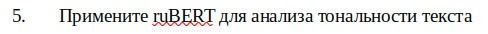

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn.functional import softmax

In [2]:
tokenizer = BertTokenizer.from_pretrained("MaxKazak/ruBert-base-russian-emotion-detection")
model = BertForSequenceClassification.from_pretrained("MaxKazak/ruBert-base-russian-emotion-detection")

In [12]:
text = 'Грустно что-то'
# Тональность текста определяется как сумма тональностей слов, содержащихся в размеченных словарях.

inputs  = tokenizer(text, return_tensors="pt", truncation=True)

with torch.no_grad():
    logits = model(**inputs).logits
probabilities = softmax(logits, dim=1)

emo_class = torch.argmax(logits, dim=1).item()

emo_labels = model.config.id2label
emo_name = emo_labels[emo_class]

print(f'Текст {text}')
print(f"Классы: {emo_labels}")
print(f"Класс тональности: {emo_class}")
print(f"Вероятности для каждого класса: {probabilities.numpy()}")
print(f'Предсказанная эмоция: {emo_name}')

Текст Грустно что-то
Классы: {0: 'joy', 1: 'interest', 2: 'surpise', 3: 'sadness', 4: 'anger', 5: 'disgust', 6: 'fear', 7: 'guilt', 8: 'neutral'}
Класс тональности: 3
Вероятности для каждого класса: [[6.8994466e-04 2.3893076e-03 2.3787048e-04 9.8489469e-01 3.2889752e-03
  9.2210190e-04 9.3220116e-04 7.5554400e-04 5.8894316e-03]]
Предсказанная эмоция: sadness
